# Import librairies

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import itertools as I
import math

from sklearn.metrics import mean_squared_error

# keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras.layers as L
import keras.models as M
import keras.optimizers as O
from keras.preprocessing import sequence as S
from pandas import DataFrame

# Loading Dataset

In [ ]:
train_features = pd.read_csv('/work/dengue_features_train.csv', index_col=[0,1,2]) #index_col refer to city, year, weekofyear
train_labels = pd.read_csv('/work/dengue_labels_train.csv', index_col=[0,1,2])

In [ ]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [ ]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [ ]:
sj_train_features.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
     19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
     20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
     21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
     22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
1990 18                         12.42             297.572857   
     19                         22.82             298.211429   
     20                         34.54             298.781429   
     21                         15.36             298.987143   
     22                          7.52             299.518571   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
1990 18                     297.742857                   292.414286   
     19                     298.442857                   293.951429   
     20                     298.878571                   295.434286   
     21                     299.228571                   295.310000   
     22                     299.664286                   295.821429   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
1990 18                              299.8  ...   
     19                              300.9  ...   
     20                              300.5  ...   
     21                              301.4  ...   
     22                              301.9  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
1990 18                                    32.00   
     19                                    17.94   
     20                                    26.10   
     21                                    13.90   
     22                                    12.20   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
1990 18                                     73.365714   
     19                                     77.368571   
     20                                     82.052857   
     21                                     80.337143   
     22                                     80.460000   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
1990 18                                 12.42   
     19                                 22.82   
     20                                 34.54   
     21                                 15.36   
     22                                  7.52   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
1990 18                                      14.012857           2.628571   
     19                                      15.372857           2.371429   
     20                                      16.848571           2.300000   
     21                                      16.672857           2.428571   
     22                                      17.210000           3.014286   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
1990 18                   25.442857                 6.900000   
     19                   26.714286                 6.371429   
     20                   26.714286                 6.485714   
     21                   27.471429                 6.771429   
     22                   28.942857                 9.371429   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
year weeko

# Preprocess

In [ ]:
#drop week start date 
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#Function to count missing values on the dataset 
def missing_values_table(df):
    
    mis_val = df.isnull().sum()

    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)
    
    # Print some summary information
    print("Your selected dataframe has {} columns.".format(df.shape[1]) + '\n' + 
    "There are {} columns that have missing values.".format(mis_val_table_ren_columns.shape[0]))
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

missing_values_table(sj_train_features)


Your selected dataframe has 20 columns.
There are 20 columns that have missing values.


,Missing Values,% of Total Values
ndvi_ne,191,20.41
ndvi_nw,49,5.24
ndvi_se,19,2.03
ndvi_sw,19,2.03
reanalysis_sat_precip_amt_mm,9,0.96
precipitation_amt_mm,9,0.96
station_min_temp_c,6,0.64
station_max_temp_c,6,0.64
station_diur_temp_rng_c,6,0.64
station_avg_temp_c,6,0.64


In [ ]:

missing_values_table(sj_train_features)

Your selected dataframe has 20 columns.
There are 20 columns that have missing values.


,Missing Values,% of Total Values
ndvi_ne,191,20.41
ndvi_nw,49,5.24
ndvi_se,19,2.03
ndvi_sw,19,2.03
reanalysis_sat_precip_amt_mm,9,0.96
precipitation_amt_mm,9,0.96
station_min_temp_c,6,0.64
station_max_temp_c,6,0.64
station_diur_temp_rng_c,6,0.64
station_avg_temp_c,6,0.64


Text(0.5, 0, 'Time')

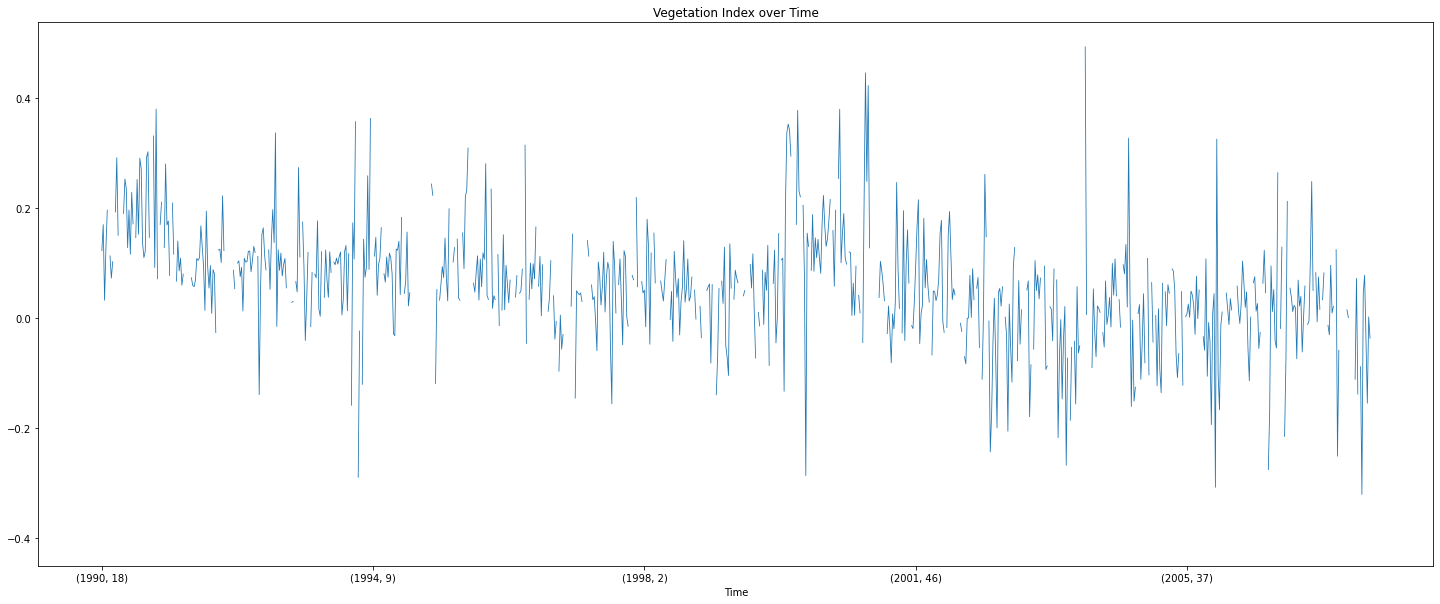

In [ ]:
plt.figure(figsize=(25, 10))
(sj_train_features
     .ndvi_ne
     .plot
     .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

In [ ]:
#Method to fill the missing value by the value before, since we are working on time series , this method seems to be
#the best way to fill missing values .
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:4468: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
#Add the total cases column to the features data set .
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

<AxesSubplot:>

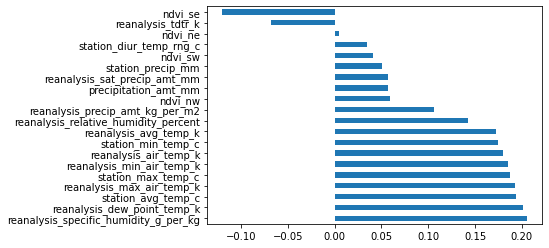

In [ ]:
# San Juan
(sj_correlations.total_cases
     .drop('total_cases')
     .sort_values(ascending=False)
     .plot
     .barh())

<AxesSubplot:>

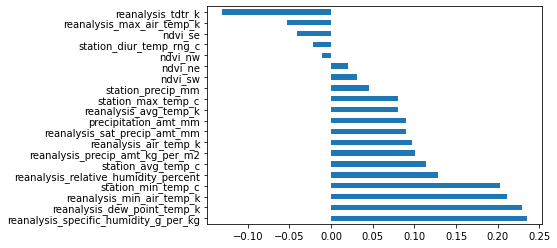

In [ ]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases')
     .sort_values(ascending=False)
     .plot
     .barh())


Conclusion for these two viz: 
- reanalysis_specific_humidity_g_per_kg and reanalysis_dew_point_temp_k ==&gt; strongly correlated (humid climate) 
- average, min and max temperature also
- precipitation too 

then , features  to keep : 

reanalysis_specific_humidity_g_per_kg

reanalysis_dew_point_temp_k

station_avg_temp_c

station_min_temp_c

In [ ]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c']
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [ ]:
sj, iq = preprocess_data('/work/dengue_features_train.csv',
                                    labels_path="/work/dengue_labels_train.csv")

In [ ]:
sj_train_labels.head()

total_cases
year weekofyear             
1990 18                    4
     19                    5
     20                    4
     21                    3
     22                    6

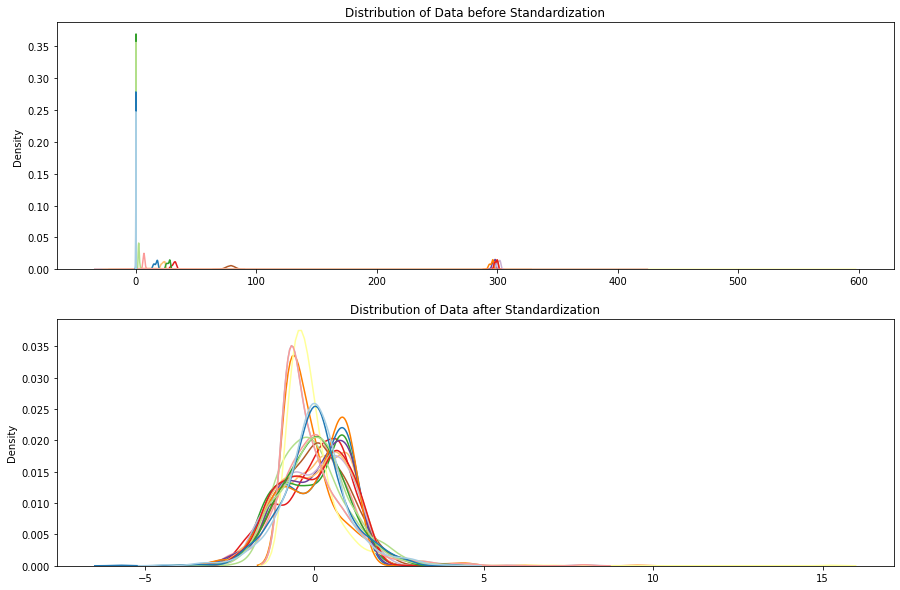

In [ ]:
#Standardization of our dataset, we will use San juan as example here
keepCols =  ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 
'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent','reanalysis_sat_precip_amt_mm', 
'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 	
'station_precip_mm']

scaler = StandardScaler()
scaled_df = scaler.fit_transform(sj_train_features[keepCols])
scaled_df_sj = pd.DataFrame(scaled_df, columns=keepCols)

plt.rcParams["figure.figsize"]=[15,10]
plt.subplot(211)
plt.title('Distribution of Data before Standardization')
sns.kdeplot(data=sj_train_features[keepCols], legend=None, palette="Paired")
plt.subplot(212)
plt.title('Distribution of Data after Standardization')
sns.kdeplot(data=scaled_df_sj, legend=None, palette="Paired")
plt.draw()

# Random Forest

In [ ]:
randomforest=RandomForestRegressor(n_estimators=30)

In [ ]:
scaled_df_sj.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,0.618730,0.406732,0.386803,0.207545,-0.513013,-1.282015,-1.253898,-1.714497,-1.265623,-1.079864,0.045021,-1.538475,-0.513013,-1.624972,0.228762,-1.100409,0.173508,-1.278687,-1.723054,-0.367775
1,1.069847,0.827328,-0.240873,-0.189115,-0.279993,-0.765638,-0.679726,-0.734948,-0.391773,-0.693609,-0.350886,-0.355236,-0.279993,-0.753081,-0.287676,-0.201443,-0.459811,0.059942,-0.261722,-0.620780
2,-0.242970,1.164151,-0.330476,0.086137,-0.017398,-0.304710,-0.322333,0.210006,-0.709537,0.001651,-0.121114,1.029432,-0.017398,0.192993,-0.431131,-0.201443,-0.322877,0.350949,0.136822,0.500648
3,0.676272,1.952837,0.891947,1.251919,-0.447140,-0.138360,-0.035247,0.130805,0.005432,-0.230103,-0.464646,0.522269,-0.447140,0.080343,-0.172912,0.333897,0.019457,0.991163,0.468943,-0.778054
4,1.320680,2.140254,1.302732,1.457218,-0.622801,0.291378,0.322146,0.456714,0.402637,0.156153,-0.512515,0.558586,-0.622801,0.424704,1.003419,1.374273,3.134700,1.980584,0.867488,-0.716512


In [ ]:
X = scaled_df_sj
y = sj['total_cases']

In [ ]:
randomforest.fit(X, y)

RandomForestRegressor(n_estimators=30)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=42)

In [ ]:
regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=None)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)

In [ ]:
y_pred2=regressor.predict(X)

In [ ]:
#scores on train and test 
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))

0.9269127407313509
0.4521867201795493


Text(0.5, 1.0, 'Predictions vs Actual total cases')

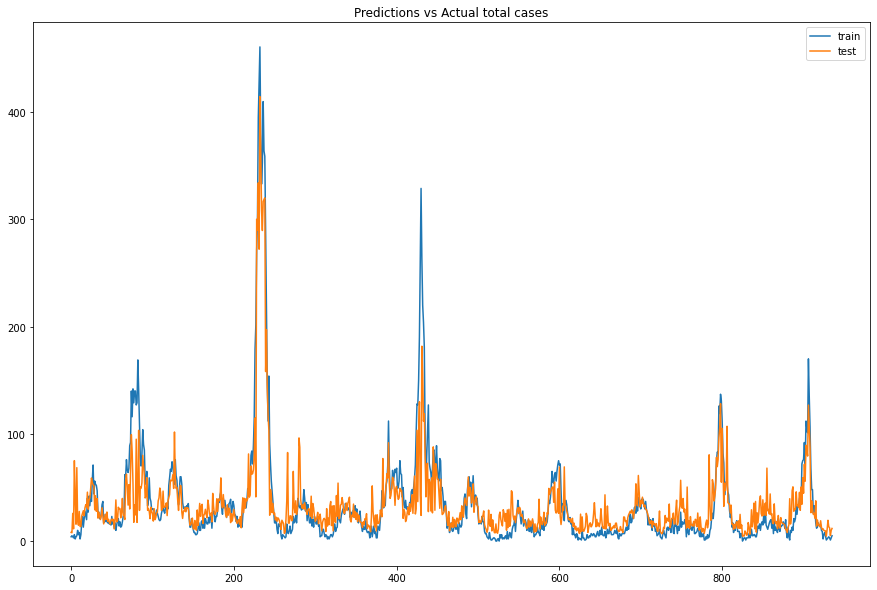

In [ ]:
plt.plot(np.array(y), label='train')
plt.legend()
plt.plot(y_pred2, label='test')
plt.legend()
plt.title("Predictions vs Actual total cases") 


In [ ]:
X = scaled_df
y = sj_train_features['total_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# PCA &amp; Random Forest

In [ ]:
x = []
df_test = pd.DataFrame()

for i in range(1,20):
    X = scaled_df
    y = sj_train_features['total_cases']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    pca = PCA(n_components=i)
    pca.fit(X_train)
    X  = pca.transform(X)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    randomforest=RandomForestRegressor(n_estimators=30)
    randomforest.fit(X, y)
    x.append(randomforest.score(X, y))
    
df_test['PCA_choice'] = range(1,20)
df_test['Score'] = x
df_test.style.hide_index()
#plt.plot(, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

PCA_choice,Score
1,0.794297
2,0.841268
3,0.839386
4,0.828052
5,0.845591
6,0.815980
7,0.847175
8,0.829848
9,0.839044
10,0.842657


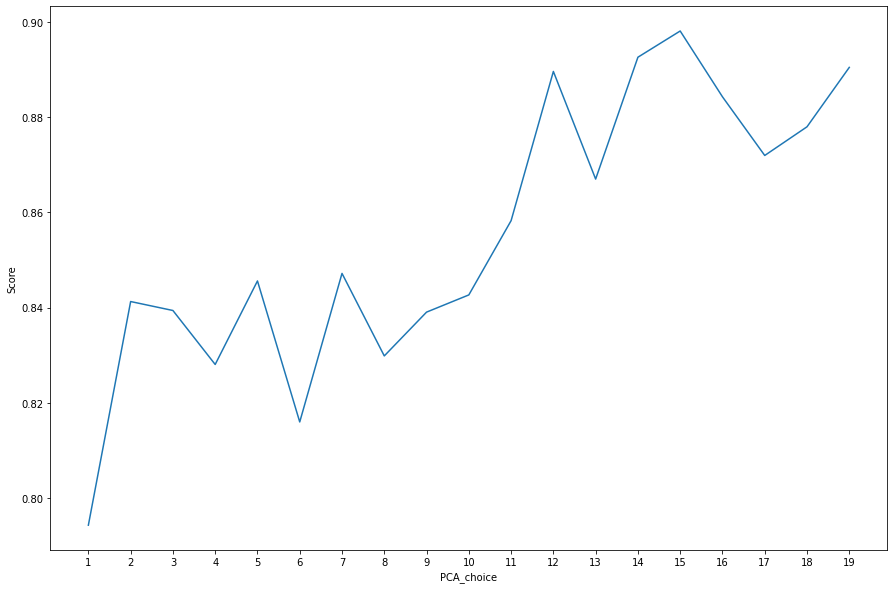

In [ ]:
x=df_test['PCA_choice']
y=df_test['Score']
plt.plot(x, y)
plt.xticks(x)
plt.xlabel('PCA_choice')
plt.ylabel('Score')
plt.draw()

In [ ]:
X = scaled_df
y = sj_train_features['total_cases']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pca = PCA(n_components=13)
pca.fit(X_train)
X  = pca.transform(X)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
randomforest=RandomForestRegressor(n_estimators=30)
randomforest.fit(X, y)

RandomForestRegressor(n_estimators=30)

In [ ]:
regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=None)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)

In [ ]:
y_pred2=regressor.predict(X)

In [ ]:
#scores on train and test 
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))

0.8888956372659632
0.24602940000540108


Text(0.5, 1.0, 'Predictions vs Actual total cases with PCA')

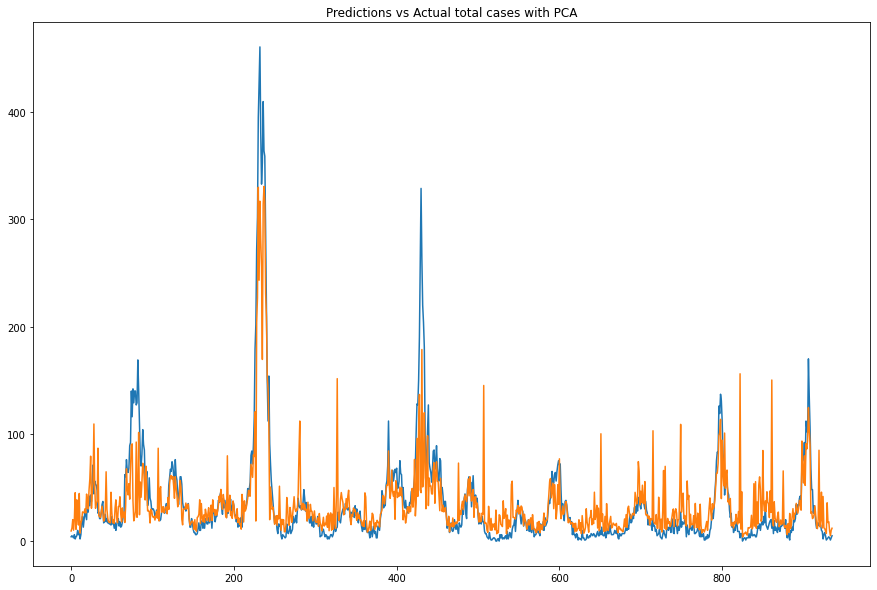

In [ ]:
plt.plot(np.array(y), label='train')
plt.plot(y_pred2, label='test')
plt.title("Predictions vs Actual total cases with PCA") 

# RNN

In [ ]:
 #function converts a time series for supervised learning
# modified from 
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    arguments:
    data: list of values
    n_in: lookback time period(s)
    n_out: prediction time period(s)
    dropnan: True/False
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# create function to create models and display results of the loss ( here it's mean absolute error)

def run_lstm(dataset_in, dataset_name_string, chart_title, start_col, end_col, 
             lookback_periods, train_proportion, dropout_proportion, epoch_count):
    '''
    dataset_in: pandas dataframe
    dataset_name_string: string for name of dataset_in, used in report
    chart_title: string for plot title
    start_col: index of column to start training data with
    end_col: index of column to end the training date from
    lookback_periods: prior time periods to use when predicting
    train_proportion: proportion of the dataset to use for the training data (0-1)
    dropout_proportion: proportion of nodes in the dropout layer to randomly disable during an epoch
    epoch_count: number of epochs to run the model
    '''
    
    #get values, starting with start_col, which in these datasets skips 'week_start_date'
    dataset = dataset_in.copy()
    values = dataset[dataset.columns[start_col:end_col]].values

    # ensure all data are of type float32
    values = values.astype('float32')

    # normalize all features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # convert data to proper format for supervised learning using lookback_periods
    reframed = series_to_supervised(scaled, lookback_periods, 1)

    # split the data into train and test sets based on given proportion
    values = reframed.values
    n_train_weeks = math.floor(len(values) * train_proportion)
    train = values[:n_train_weeks, :]
    test = values[n_train_weeks:, :]
    
    # split into explanatry (as opposed to independant) and response variables. 
    # Last column, 'total_cases' is the response variable
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    # Create an LSTM model 
    model = Sequential()
    #First Layer
    model.add(LSTM(units = 50, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
      # dropout layer
    model.add(Dropout(dropout_proportion))
    #Second layer
    model.add(LSTM(units = 50, return_sequences = True))
       # dropout layer
        #THIRD layer
    model.add(LSTM(units = 50, return_sequences = True))
       # dropout layer
    model.add(Dropout(dropout_proportion))

    model.add(Dense(50, activation='relu'))

    # output layer
    model.add(Dense(1))

    model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

    # fit model
    history = model.fit(train_X, train_y, epochs=epoch_count, batch_size=72, 
                        validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    # output
    print('Dataset name: {}'.format(dataset_name_string))
    print('Lookback window periods: {}'.format(lookback_periods))
    print('Training proportion: {}'.format(train_proportion))
    print('Dropout proportion: {}'.format(dropout_proportion))
    print('last epoch loss: {}'.format(history.history['loss'][-1]))
    print('last epoch val_loss: {}'.format(history.history['val_loss'][-1]))
# plot history
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel('loss proportion', fontsize=20)
    plt.legend(fontsize=20)
    plt.title('Location: {}'.format(chart_title), fontsize=24)
    plt.show()

Dataset name: sj
Lookback window periods: 4
Training proportion: 0.87
Dropout proportion: 0.3
last epoch loss: 0.019404755905270576
last epoch val_loss: 0.01419149897992611


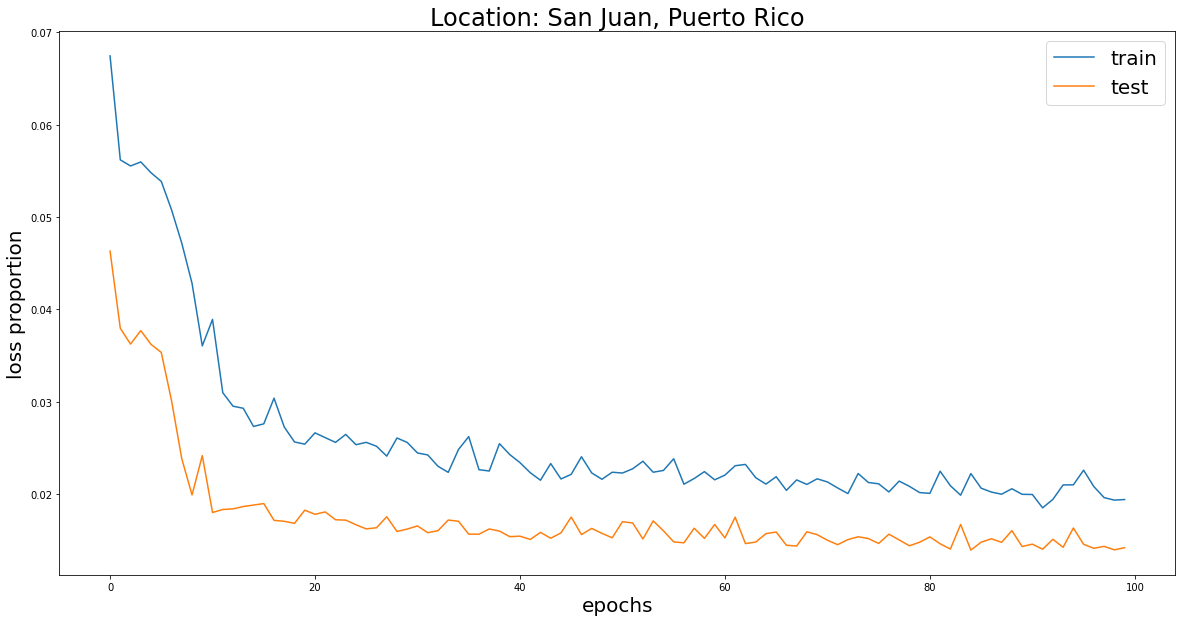

In [ ]:
# for reference
# run_lstm(dataset_in, dataset_name_string, chart_title, start_col, end_col, 
#          lookback_periods, train_proportion, dropout_proportion, epoch_count)

# San Juan
run_lstm(sj, 'sj', 'San Juan, Puerto Rico', 1, 5, 4, .87, .3, 100)

In [ ]:
# create function to create models and display mae

def run_lstm_mae(dataset_in, dataset_name_string, chart_title, start_col, end_col, 
             lookback_periods, train_proportion, dropout_proportion, epoch_count):
    '''
    dataset_in: pandas dataframe
    dataset_name_string: string for name of dataset_in, used in report
    chart_title: string for plot title
    start_col: index of column to start training data with
    end_col: index of column to end the training date from
    lookback_periods: prior time periods to use when predicting
    train_proportion: proportion of the dataset to use for the training data (0-1)
    dropout_proportion: proportion of nodes in the dropout layer to randomly disable during an epoch
    epoch_count: number of epochs to run the model
    '''
    
    #get values, starting with start_col, which in these datasets skips 'week_start_date'
    dataset = dataset_in.copy()
    values = dataset[dataset.columns[start_col:end_col]].values

    # ensure all data are of type float32
    values = values.astype('float32')

    # normalize all features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # convert data to proper format for supervised learning using lookback_periods
    reframed = series_to_supervised(scaled, lookback_periods, 1)

    # split the data into train and test sets based on given proportion
    values = reframed.values
    n_train_weeks = math.floor(len(values) * train_proportion)
    train = values[:n_train_weeks, :]
    test = values[n_train_weeks:, :]
    
    # split into explanatry (as opposed to independant) and response variables. 
    # Last column, 'total_cases' is the response variable
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    # Create an LSTM model with a dropout layer 
    # and number of epochs specified
    model = Sequential()
    
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))

    # dropout layer
    model.add(Dropout(dropout_proportion))

    model.add(Dense(50, activation='relu'))

    # output layer
    model.add(Dense(1))

    model.compile(loss='mae', optimizer='adam')

    # fit model
    history = model.fit(train_X, train_y, epochs=epoch_count, batch_size=72,
                        validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    
    val_mae = model.evaluate(test_X, test_y, verbose=0)

    preds = model.predict(test_X)

    # fit model
    history = model.fit(train_X, train_y, epochs=epoch_count, batch_size=72,
                        validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    
    val_mae = model.evaluate(test_X, test_y, verbose=0)

    preds = model.predict(test_X)

    
    
    # output
    print('Dataset name: {}'.format(dataset_name_string))
    print('Lookback window periods: {}'.format(lookback_periods))
    print('Training proportion: {}'.format(train_proportion))
    print('Dropout proportion: {}'.format(dropout_proportion))
    print('last epoch loss: {}'.format(history.history['loss'][-1]))
    print('last epoch val_loss: {}'.format(history.history['val_loss'][-1]))

#     # plot history
    plt.figure(figsize=(20,10))
    plt.plot(preds, label='predictions')
    plt.plot(test_y, label='actual value')
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel('total_cases', fontsize=20)
    plt.legend(fontsize=20)
    plt.title('Location: {}'.format(chart_title), fontsize=24)
    plt.show()
    
    return val_mae

Dataset name: sj
Lookback window periods: 4
Training proportion: 0.87
Dropout proportion: 0.5
last epoch loss: 0.0180885661393404
last epoch val_loss: 0.014638306573033333


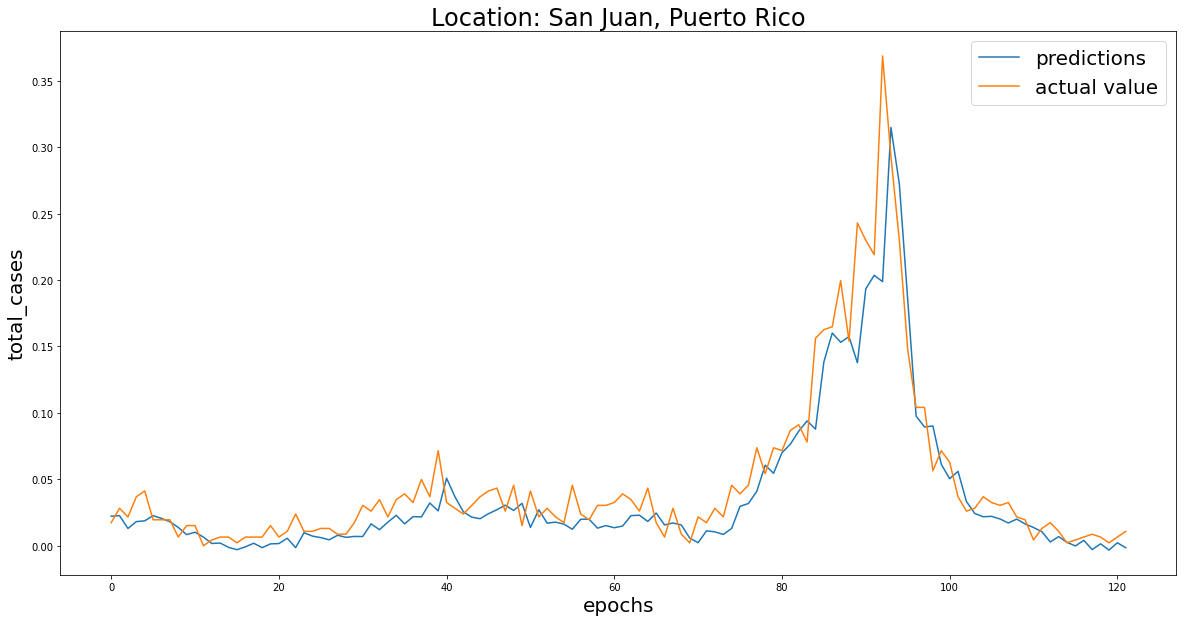

In [ ]:
# look at the mae
temp = run_lstm_mae(sj, 'sj', 'San Juan, Puerto Rico', 1, 5, 4, .87, .5, 100)

In [ ]:
#MAE Score with our RNN 
temp

0.014638306573033333

# RNN &amp; PCA

In [ ]:
#we saw that n_components = 13 gives the best score on the random forest , so we will try 13 with the RNN too.
pca=PCA(n_components=13)
pca.fit(sj_train_features)

PCA(n_components=13)

In [ ]:
columns = ['pca_%i' % i for i in range(13)]
df_pca = DataFrame(pca.transform(sj_train_features), columns=columns, index=sj_train_features.index)
df_pca.head()

pca_0      pca_1      pca_2      pca_3     pca_4  \
year weekofyear                                                         
1990 18         -35.143097 -25.410252  13.483849   5.616917  6.496043   
     19         -28.569434 -26.375679  -6.651728   9.830230  1.255577   
     20          -1.740640 -30.252919   2.713525 -14.762533 -1.986829   
     21         -40.715047 -26.882784  -6.898718  11.018390 -3.057952   
     22         -50.256463 -22.515284  -3.622647   6.992659 -5.499619   

                    pca_5     pca_6     pca_7     pca_8     pca_9    pca_10  \
year weekofyear                                                               
1990 18          2.194212  0.089590  0.310565  0.360085  0.020115  0.446210   
     19         -0.495481  0.520546 -0.822553 -0.254930  0.549987  0.079339   
     20         -3.234241  0.564172 -0.394180  0.233509  0.379201 -0.291799   
     21         -2.217849  1.107259 -0.699181 -0.293173  0.531007 -0.179098   
     22         -1.215782  3.410104 -0.351379  0.467523 -0.903134 -0.148323   

                   pca_11    pca_12  
year weekofyear                      
1990 18          0.029223 -0.449121  
     19          0.228963 -0.139839  
     20         -0.520229  0.119935  
     21         -0.053165  0.231672  
     22         -0.000190  0.074618

In [ ]:
#We concat the features with pca and the column total cases we want to predict 
df_pca_all=pd.concat([df_pca,sj_train_labels],axis=1)

Dataset name: Dataframe_pca
Lookback window periods: 4
Training proportion: 0.87
Dropout proportion: 0.5
last epoch loss: 0.014576492831110954
last epoch val_loss: 0.011429072357714176


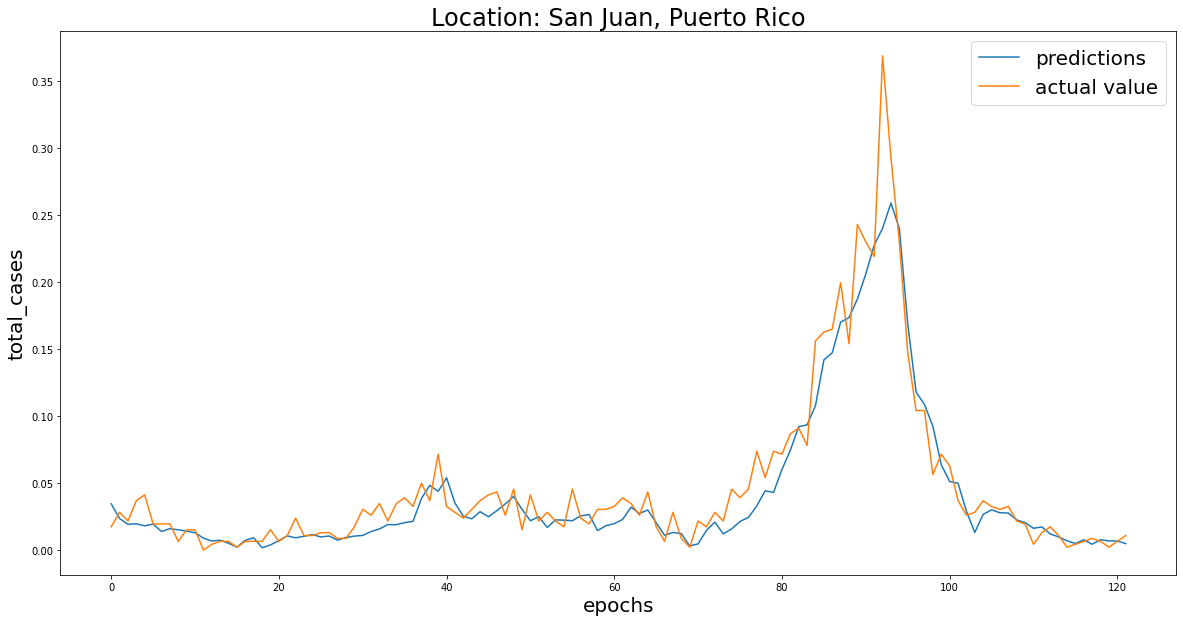

In [ ]:
# We fit the RNN on the pca dataset 
#look at the mae
temp2 = run_lstm_mae(df_pca_all, 'Dataframe_pca', 'San Juan, Puerto Rico', 1, 14, 4, .87, .5, 100)

In [ ]:
#Score MAE with the pca 
print(temp2)

#Score without the pca and with only 4 features : 0.012
#The mae score is better without the pca 

print(temp)

0.013413529843091965


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2e9239e8-0551-4959-8264-1b8c41e681a8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>